In [1]:
#import necessary packages and libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import sklearn.model_selection as ms
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

from numpy import inf
from numpy import e


In [2]:
#Import the train and test datasets 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train_id = train["Id"]
test_id = test["Id"]
train_SalePrice = train["SalePrice"].copy()

print("The training set contains {} rows and {} columns".format(train.shape[0], train.shape[1]))
print("The test set contains {} rows and {} columns".format(test.shape[0], test.shape[1]))

#Create a dataset, excluding id and Saleprice, to explore by combining the train and test sets
all_data = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']])

print("-----------------------------------------------------")
print("There are {} numeric features and {} categorical features".format(all_data.select_dtypes(["int","float"]).shape[1], all_data.select_dtypes(["object"]).shape[1]))

The training set contains 1460 rows and 81 columns
The test set contains 1459 rows and 80 columns
-----------------------------------------------------
There are 36 numeric features and 43 categorical features


In [3]:
#Take a closer look at the numeric variables in the dataset
numerics = all_data.select_dtypes(["int","float"])
numeric_chars = pd.DataFrame()
numeric_chars["Skew"] = numerics.skew()
numeric_chars["Kurtosis"] = numerics.kurtosis()
numeric_chars["Class"] = numerics.dtypes
numeric_chars["Min"] = numerics.apply(min)
numeric_chars["Max"] = numerics.apply(max)
numeric_chars["Mean"] = numerics.mean()

numeric_chars["Missing Values"] = numerics.isna().sum()

In [4]:
#Based on the data dictionary, MSSubClass and MoSold should not be a numeric variables so that will be converted to categorical. 
#There are variables that have quite a bit of skew. Reducing some of the skew, particularly SalePrice, may improve model performance for certain models. 
#There are 11 variables with missing values, imputation is needed
#Some variables have a much larger range than others. Normalization may be needed for certain models to perform optimally
numeric_chars.sort_values(by="Missing Values",ascending=False)

,Skew,Kurtosis,Class,Min,Max,Mean,Missing Values
LotFrontage,1.503278,11.295921,float64,21.0,313.0,69.305795,486
GarageYrBlt,-0.382150,1.809845,float64,1895.0,2207.0,1978.113406,159
MasVnrArea,2.602589,9.254343,float64,0.0,1600.0,102.201312,23
BsmtHalfBath,3.932018,14.848079,float64,0.0,2.0,0.061364,2
BsmtFullBath,0.624062,-0.735693,float64,0.0,3.0,0.429894,2
TotalBsmtSF,1.162882,9.151099,float64,0.0,6110.0,1051.777587,1
GarageCars,-0.218373,0.238198,float64,0.0,5.0,1.766621,1
BsmtFinSF1,1.425722,6.904832,float64,0.0,5644.0,441.423235,1
BsmtFinSF2,4.147456,18.836540,float64,0.0,1526.0,49.582248,1
BsmtUnfSF,0.919824,0.403617,float64,0.0,2336.0,560.772104,1


In [5]:
#Change the MSSubClass variable to categorical
all_data["MSSubClass"] = all_data["MSSubClass"].apply(str)
all_data["MoSold"] = all_data["MoSold"].apply(str)

In [6]:
#The variables below have missing data that need to be imputed 
missing_numeric_data = numerics.isna().sum().sort_values(ascending=False)
missing_numeric_data[missing_numeric_data > 0]

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
dtype: int64

The mean LotFrontage is 69.30579531442663 and the mode LotFrontage is 60.0


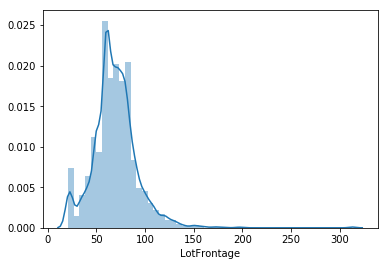

In [7]:
#Inspect LotFrontage to determine which imputation method would be optimal
%matplotlib inline
sns.distplot(numerics["LotFrontage"].dropna())
print("The mean LotFrontage is {} and the mode LotFrontage is {}".format(numerics["LotFrontage"].mean(), numerics["LotFrontage"].mode()[0] ))

#Based on the distribution plot, it seems to make sense to use the mode to impute missing LotFrontage values
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(train["LotFrontage"].mode()[0])

In [8]:
#Inspect the GarageYrBlt to see if imputation is necessary or if it is redundant
all_data.loc[all_data["GarageYrBlt"]==all_data["YearBuilt"],:].shape[0]/all_data.shape[0]

#About 75 percent of garages were built the same year as the house itself. Based on that, this column may be redundant.
#We will drop this column
all_data.drop(["GarageYrBlt"],axis=1,inplace=True)

In [9]:
#Based on the data dictionary, there are houses with no masonry veneer so the MasVnrArea column can be imputed with zero if the value is missing
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [10]:
#The safest assumption for missing values in the two basement bathroom columns is that either the house has no basement or no bathrooms in the basement. 
#Those columns will be imputed with 0's
all_data["BsmtHalfBath"] = all_data["BsmtHalfBath"].fillna(0)
all_data["BsmtFullBath"] = all_data["BsmtFullBath"].fillna(0)


In [11]:
#The rest of the columns with missing values pertain to the garage or basement of the home. 
#The safe assumption would be to assume that the home does not have a basement or garage. Those columns will be imputed with 0
still_missing = all_data.select_dtypes(["int","float"]).isna().sum()
to_impute = still_missing[still_missing > 0].index

for i in to_impute:
    all_data[i] = all_data[i].fillna(0)

In [12]:
#Make sure all numeric columns have been imputed 
all_data.select_dtypes(["int","float"]).isna().sum().sort_values(ascending=False).head(10)

YrSold          0
BsmtFullBath    0
LotArea         0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
dtype: int64

In [13]:
#Create a temporary train set to analyze the SalePrice variable
temp_train = all_data.copy().iloc[:train.shape[0]]
temp_train["SalePrice"] = train_SalePrice

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


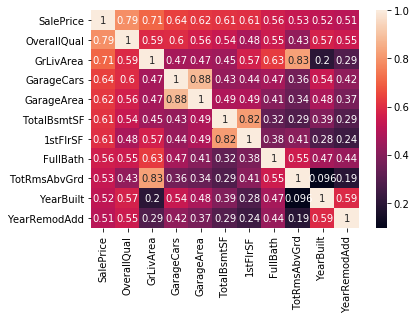

In [14]:
#Initial look at which variables are most correlated with SalePrice and may present multicollinearity issues
numerics = temp_train.copy().select_dtypes(["int","float"])
print(numerics.corr()["SalePrice"].sort_values(ascending=False).head(11))
most_correlated = numerics.corr()["SalePrice"].sort_values(ascending=False).head(11).index
sns.heatmap(numerics.loc[:,most_correlated].corr(), annot = True)

#There's a good amount of multicollinearity between certain columns. 
#GarageArea and GarageCars seem to be very correlated which makes sense because GarageArea is the size of the garage in square feet and GarageCar is the size of the garage in car capacity. One can be removed
#1stFlrSF and TotalBsmtSF also seem to be very highly correlated. This also makes sense because they indicate how large the house is. Other columns indicating square foot should also be examined. 
#GrLivArea and TotRmsAbvGrd also are very highly correlated. This makes intuitive sense because the more rooms there are, more likely, the bigger the house. One will be removed
all_data.drop(["GarageArea","TotRmsAbvGrd"],axis=1, inplace=True)

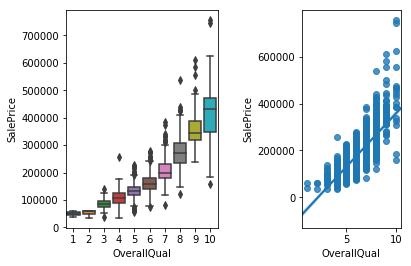

In [15]:
#examine some of the variables that are highly correlated with SalePrice
#There is a clear distinct linear relationship between SalePrice and OverallQual. This column can be left alone
plt.subplot(1,2,1)
sns.boxplot(x="OverallQual", y="SalePrice",data=numerics)
plt.subplot(1,3,3)
sns.regplot(x="OverallQual", y="SalePrice",data=numerics)

Text(0.5,1,'GrLiveArea vs SalePrice')

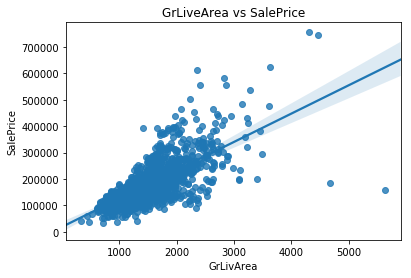

In [16]:
#There is a linear relationship between GrLivArea and SalePrice. There are some notable outliers with larger houses being much cheaper and some smaller houses being more expensive. 
#Those points may skew the model and should be removed later on
sns.regplot(x="GrLivArea", y="SalePrice",data=numerics)
plt.title("GrLiveArea vs SalePrice")


Text(0.5,1,'GarageCars vs SalePrice')

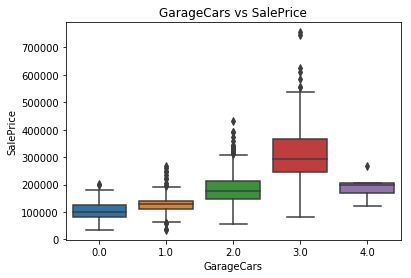

In [17]:
#Boxplot of GsrageCars vs SalePrice. Again, houses worth more than 7000000 appear to be outliers. 
#Houses with garage thats are able to fit 4 cars seem to be cheaper than they should be.  
sns.boxplot(x="GarageCars",y="SalePrice",data=numerics)
plt.title("GarageCars vs SalePrice")

Text(0.5,1,'SalePrice versus YearBuilt')

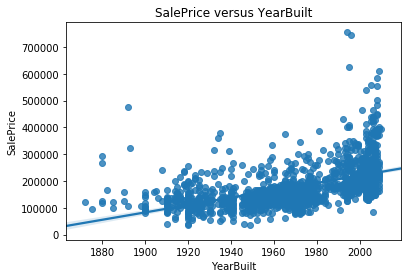

In [18]:
#There's a clear positive correlatioon between the year the house was built and sale price
sns.regplot(train["YearBuilt"], train["SalePrice"])
plt.title("SalePrice versus YearBuilt")

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64
_________________________________


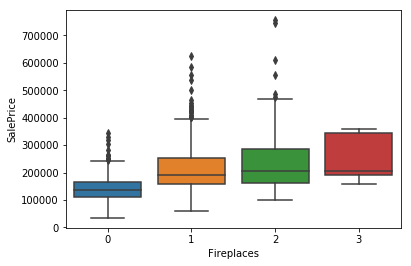

In [19]:
#There is clearly a correlation between number of fireplaces and the price of the house
print(train["Fireplaces"].value_counts())
print("_________________________________")
sns.boxplot(x="Fireplaces", y="SalePrice", data=train)

In [20]:
#Take a closer look at the categorical variables
categories = all_data.select_dtypes(["object"])
categorical_chars = pd.DataFrame()

categorical_chars["Num_Unique_Values"] = categories.apply(lambda x: x.value_counts().shape[0])
categorical_chars["Unique_Values"] = categories.apply(lambda x: list(x.value_counts().index))
categorical_chars["Num_Missing"] = categories.isna().sum()

In [21]:
#Many of the variables have some missing values
#Based on the data dictionary, the null value for most of the column means that the house does not have a certain feature
categorical_chars.sort_values(by="Num_Missing",ascending=False)

,Num_Unique_Values,Unique_Values,Num_Missing
PoolQC,3,"[Ex, Gd, Fa]",2909
MiscFeature,4,"[Shed, Gar2, Othr, TenC]",2814
Alley,2,"[Grvl, Pave]",2721
Fence,4,"[MnPrv, GdPrv, GdWo, MnWw]",2348
FireplaceQu,5,"[Gd, TA, Fa, Po, Ex]",1420
GarageQual,5,"[TA, Fa, Gd, Po, Ex]",159
GarageFinish,3,"[Unf, RFn, Fin]",159
GarageCond,5,"[TA, Fa, Gd, Po, Ex]",159
GarageType,6,"[Attchd, Detchd, BuiltIn, Basment, 2Types, Car...",157
BsmtExposure,4,"[No, Av, Gd, Mn]",82


In [22]:
#The Electrical column has missing values that need to be imputed
print(all_data["Electrical"].value_counts()/all_data.shape[0])
#An overwhelming majority of the electrical column is SBrkr, so that may be the best guess to fill that row,
all_data["Electrical"] = all_data["Electrical"].fillna("SBrkr")

SBrkr    0.915039
FuseA    0.064406
FuseF    0.017129
FuseP    0.002741
Mix      0.000343
Name: Electrical, dtype: float64


In [23]:
#Handle the rest of the categorical columns with null values by imputing NA, None, or the majority class
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("NA")
all_data["GarageType"] = all_data["GarageType"].fillna("NA")
all_data["GarageCond"] = all_data["GarageCond"].fillna("NA")
all_data["GarageFinish"] = all_data["GarageFinish"].fillna("NA")
all_data["GarageQual"] = all_data["GarageQual"].fillna("NA")
all_data["BsmtFinType2"] = all_data["BsmtFinType2"].fillna("NA")
all_data["BsmtFinType1"] = all_data["BsmtFinType1"].fillna("NA")
all_data["BsmtQual"] = all_data["BsmtQual"].fillna("NA")
all_data["BsmtCond"] = all_data["BsmtCond"].fillna("NA")
all_data["BsmtExposure"] = all_data["BsmtExposure"].fillna("NA")
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["Electrical"] = all_data["Electrical"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["PoolQC"] = all_data["PoolQC"].fillna("No Pool")
all_data["Fence"] = all_data["Fence"].fillna("Fence")
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna("None")
all_data["BsmtExposure"] = all_data["BsmtExposure"].fillna("NA")

In [24]:
#The remaining columns with missing values will be imputed with the majority class
remaining_missing = all_data.isna().sum().sort_values(ascending=False)
remaining_missing = remaining_missing[remaining_missing > 0 ].index
for i in remaining_missing:
    print(categories[i].value_counts()/categories.shape[0])
    print("______________________________________________________________")

RL         0.775951
RM         0.157588
FV         0.047619
RH         0.008907
C (all)    0.008565
Name: MSZoning, dtype: float64
______________________________________________________________
Typ     0.930798
Min2    0.023981
Min1    0.022268
Mod     0.011990
Maj1    0.006509
Maj2    0.003083
Sev     0.000685
Name: Functional, dtype: float64
______________________________________________________________
AllPub    0.998972
NoSeWa    0.000343
Name: Utilities, dtype: float64
______________________________________________________________
TA    0.511134
Gd    0.394313
Ex    0.070230
Fa    0.023981
Name: KitchenQual, dtype: float64
______________________________________________________________
VinylSd    0.351148
MetalSd    0.154162
HdBoard    0.151422
Wd Sdng    0.140802
Plywood    0.075711
CemntBd    0.043165
BrkFace    0.029805
WdShing    0.019185
AsbShng    0.015074
Stucco     0.014731
BrkComm    0.002055
Stone      0.000685
CBlock     0.000685
AsphShn    0.000685
ImStucc    0.000343
N

In [25]:
all_data["MSZoning"] = all_data["MSZoning"].fillna("RL")
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data["Utilities"] = all_data["Utilities"].fillna("AllPub")
all_data["KitchenQual"] = all_data["KitchenQual"].fillna("TA")
all_data["SaleType"] = all_data["SaleType"].fillna("WD")
all_data["Exterior1st"] = all_data["Exterior1st"].fillna("VinylSd")

In [26]:
#Inspect the categorical variables after null values have been imputed
#There are no more null values
categories = all_data.select_dtypes(["object"]).copy()
print(categories.isna().sum().sort_values(ascending=False).head(5))

SaleCondition    0
Foundation       0
ExterQual        0
MasVnrType       0
Exterior2nd      0
dtype: int64


In [27]:
#Check for columns that are homogenous and won't provide much information
for i in categories.columns:
    print(categories[i].value_counts()/categories.shape[0])
    print("______________________________________________________________")
    
#Street,  Utilities, LandSlope, Condition2, RoofMatl, Heating, PoolQC Can be dropped due to extreme homogeneity. 
all_data.drop(["Street", "Utilities","LandSlope","RoofMatl","Heating","Condition2","PoolQC"], axis = 1, inplace=True)

20     0.369647
60     0.196985
50     0.098321
120    0.062350
30     0.047619
160    0.043851
70     0.043851
80     0.040425
90     0.037342
190    0.020898
85     0.016444
75     0.007879
45     0.006166
180    0.005824
40     0.002055
150    0.000343
Name: MSSubClass, dtype: float64
______________________________________________________________
RL         0.777321
RM         0.157588
FV         0.047619
RH         0.008907
C (all)    0.008565
Name: MSZoning, dtype: float64
______________________________________________________________
Pave    0.995889
Grvl    0.004111
Name: Street, dtype: float64
______________________________________________________________
None    0.932169
Grvl    0.041110
Pave    0.026721
Name: Alley, dtype: float64
______________________________________________________________
Reg    0.636862
IR1    0.331620
IR2    0.026036
IR3    0.005481
Name: LotShape, dtype: float64
______________________________________________________________
Lvl    0.898253
HLS    0.041

None    0.964029
Shed    0.032545
Gar2    0.001713
Othr    0.001370
TenC    0.000343
Name: MiscFeature, dtype: float64
______________________________________________________________
6     0.172319
7     0.152792
5     0.134978
4     0.095581
8     0.079822
3     0.079479
10    0.059267
9     0.054128
11    0.048647
2     0.045564
1     0.041795
12    0.035629
Name: MoSold, dtype: float64
______________________________________________________________
WD       0.865365
New      0.081877
COD      0.029805
ConLD    0.008907
CWD      0.004111
ConLI    0.003083
ConLw    0.002741
Oth      0.002398
Con      0.001713
Name: SaleType, dtype: float64
______________________________________________________________
Normal     0.822885
Partial    0.083933
Abnorml    0.065091
Family     0.015759
Alloca     0.008222
AdjLand    0.004111
Name: SaleCondition, dtype: float64
______________________________________________________________


/Users/jungchoi/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


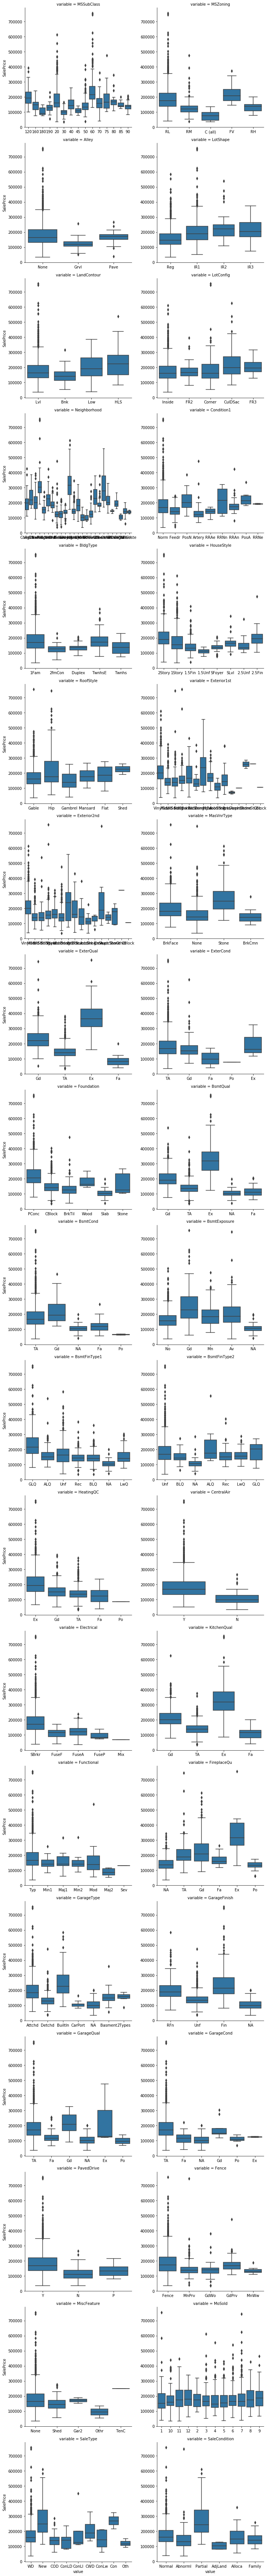

In [28]:
#Inspect the categorical variabels to determine potential binnings and relationships with SalePrice
temp_categories = all_data.select_dtypes(["object"]).copy().iloc[:train.shape[0]]
cat_sales = pd.concat([temp_categories, train["SalePrice"]], axis=1)
box_data = pd.melt(cat_sales, id_vars='SalePrice')
facet_grid = sns.FacetGrid (box_data, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
boxplots = facet_grid.map(sns.boxplot, 'value','SalePrice')

In [29]:
#Create a feature that groups the neighborhoods by wealth
indices = cat_sales.groupby(["Neighborhood"])["SalePrice"].mean().sort_values(ascending=False).index
print(len(indices))
values = np.repeat([1,2,3,4,5], 5)
neighborhoods = {indices[i] : values[i] for i in range(len(indices))}

all_data["Neighborhood_Wealth"] = all_data["Neighborhood"].map(neighborhoods).astype(str)
all_data.drop(["Neighborhood"],axis=1,inplace=True)

25


In [30]:
#There are opportunities to create new features based on the features that we already have
def feature_engineering(df):
    #Create a feature that combines all of the square foot columns into one cumulative square foot column
    SF_columns = ["1stFlrSF", "2ndFlrSF", "TotalBsmtSF"]
    df["Total_SF"] = df[SF_columns].sum(axis=1)
    
    #Create a feature to determine how many total bathrooms there are in the house. (Count halfbaths as .5)
    bathroom_columns = [i for i in df.columns if "Bath" in i]
    df["BsmtHalfBath"] = df["BsmtHalfBath"]/2
    df["HalfBath"] = df["HalfBath"]/2
    df["Total_Bathrooms"] = df[bathroom_columns].sum(axis=1)
    
    #MasVnrType indicates the type of material that the external portion of the house wall is made of
    #Based on www.angieslist.com, stone veneer costs about 17$ per square foot and brick veneer costs about 8-10. 
    #We have a MasVnrArea column so maybe the two can be combined to show how much the veneer costs total 
    material_dict = {"BrkCmn":10, "BrkFace":10, "None":0, "Stone":17}
    material_cost = df["MasVnrType"].map(material_dict)
    veneer_cost = df["MasVnrArea"] * material_cost
    df["Veneer_Cost"] = veneer_cost
    
    #Create a column indicating whether or not the house has a garage
    df["HasGarage"] = df["GarageQual"].apply(lambda x: "No" if x == "NA" else "Yes")
    
    #Based on the visualization above, it looks like certain variables can be grouped together
    #For HeatingQC there is clearly a price difference between GLQ and everything else. I believe GLQ can be binned alone and the rest binned into one value and then dummified later
    df["BsmtFinType1"] = df["BsmtFinType1"].apply(lambda x: "GLQ" if x=="GLQ" else "Non-GLQ")


    #The SaleCondition column looks like it can it can be clustered into Partial and Non-Partial based on the 
    #homogeneity of saleprices in everything other than partial. This column will be dummified after
    df["SaleCondition"] = df["SaleCondition"].apply(lambda x: "Partial" if x=="Partial" else "Non-Partial")

    #Based on the description of the condition1 variable,  it can be binned then dummified
    condition_mapper = {"RRAe":"rail","RRNn":"rail","RRAn":"rail","RRNe":"rail","Artery":"street","Feedr":"street","Norm":"normal","PosN":"park","PosA":"park"}
    df["Condition1"] = categories["Condition1"].map(condition_mapper)
    
    #All of the quality related columns are ordinal, we can transform into numeric
    quality_columns = ['ExterQual', 'BsmtQual','KitchenQual','GarageQual','FireplaceQu','HeatingQC']

    #map the quality columns into numeric columns
    mapper = {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
    for i in quality_columns:
        df[i] = pd.Series(df[i]).map(mapper)
 
    return df
    



In [31]:
#Add the features created above to the entire set and drop redundant columns
all_data = feature_engineering(all_data)

In [32]:
#Dummify the categorical variables
categories = all_data.select_dtypes(["object"])
to_dummify = categories.columns
final_dummies = pd.DataFrame()
for i in to_dummify:
    dummied = pd.get_dummies(categories[i],prefix = "{}".format(i),drop_first=True)
    final_dummies = pd.concat([final_dummies, dummied],axis=1)    
    
for i in final_dummies.columns:
    final_dummies[i] = final_dummies[i].astype("object")
numerics = all_data.select_dtypes(["int","float"])

In [33]:
#Combine the numeric variables and the dummified categorical variables
final_data = pd.concat([numerics, final_dummies],axis=1)

#Resplit into training and test sets for modeling
final_train = final_data.iloc[:train.shape[0]]
final_train["SalePrice"] = train.copy()["SalePrice"]
final_train = final_train.loc[final_train["GrLivArea"]<=4000,:]

final_test = final_data.iloc[train.shape[0]:]

/Users/jungchoi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


The skew of the SalePrice column before transformation is 1.57


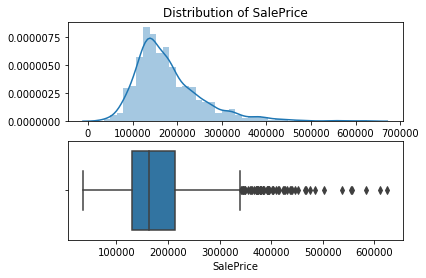

In [34]:
#The SalePrice variable has some definite right skew. Because many of the models rely on the data being normally distributed, we should perform 
#a log transformation on the SalePrice columns
print("The skew of the SalePrice column before transformation is {}".format(round(final_train["SalePrice"].skew(),2)))

%matplotlib inline
plt.subplot(2,1,1)
sns.distplot(final_train["SalePrice"])
plt.title("Distribution of SalePrice")
plt.subplot(2,1,2)
sns.boxplot(final_train["SalePrice"])

The skew of the SalePrice column after transformation is 0.06544882031646646


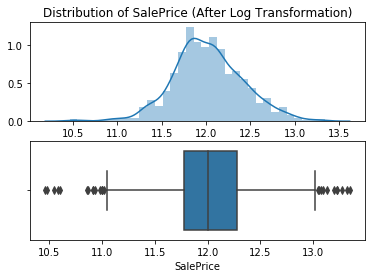

In [35]:
#After the log transformation, the SalePrice column seems to be more normally distributed and the skew has decreased
final_train["SalePrice"] = np.log(final_train["SalePrice"])
print("The skew of the SalePrice column after transformation is {}".format(final_train["SalePrice"].skew()))

%matplotlib inline
plt.subplot(2,1,1)
sns.distplot(final_train["SalePrice"])
plt.title("Distribution of SalePrice (After Log Transformation)")
plt.subplot(2,1,2)
sns.boxplot(final_train["SalePrice"])

In [36]:
#Split the data for stacking
x = final_train.drop(["SalePrice"],axis=1)
y = final_train["SalePrice"]
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=.2)

In [37]:
#Use cross validation to determine optimal alpha for ridge regression
alphas = np.linspace(.005,100,30)
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train,y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

best_alpha_ridge = min(zip(alphas,cv_ridge),key=lambda x: x[1])[0]
best_rmse_ridge = min(zip(alphas,cv_ridge),key=lambda x: x[1])[1]

The best alpha for the ridge model is 31.03793103448276
The best rmse for the ridge model is 0.121729975714028


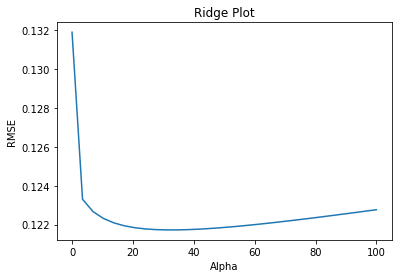

In [38]:
plt.plot(alphas,cv_ridge)
plt.title("Ridge Plot")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
print("The best alpha for the ridge model is {}".format(best_alpha_ridge))
print("The best rmse for the ridge model is {}".format(best_rmse_ridge))

In [39]:
#output the predictions from the cross validated ridge regression
final_ridge = Ridge(alpha=best_alpha_ridge)
final_ridge.fit(X_train,y_train)

ridge_train = cross_val_predict(final_ridge, X_train, y_train, cv=5)
ridge_test = cross_val_predict(final_ridge, X_test,y_test,cv=5)
rmse_ridge_train = np.sqrt(mean_squared_error(ridge_train, y_train))
rmse_ridge_test = np.sqrt(mean_squared_error(ridge_test,y_test))

print("The train rmse of the ridge regression is {}".format(round(rmse_ridge_train,4)))
print("The test rmse of the ridge regression is {}".format(round(rmse_ridge_test,4)))

The train rmse of the ridge regression is 0.122
The test rmse of the ridge regression is 0.1207


/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

The best alpha for the lasso model is 0.005
The best rmse for the lasso model is 0.12944712197187785


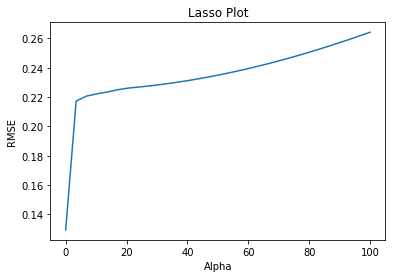

In [40]:
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean()
            for alpha in alphas]

best_alpha_lasso = min(zip(alphas,cv_lasso),key=lambda x: x[1])[0]
best_rmse_lasso = min(zip(alphas,cv_lasso),key=lambda x: x[1])[1]

plt.plot(alphas,cv_lasso)
plt.title("Lasso Plot")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
print("The best alpha for the lasso model is {}".format(best_alpha_lasso))
print("The best rmse for the lasso model is {}".format(best_rmse_lasso))

In [41]:
#Decide which features are to be used for the lasso model
lasso = Lasso(alpha=.005)
lasso.fit(x,y)
coefs = list(zip(x.columns,lasso.coef_))
best_coefs =[i[0] for i in sorted(coefs,key=lambda x: x[1],reverse=True) if i[1] >0]
print(best_coefs)

['OverallQual', 'OverallCond', 'GarageCars', 'GarageQual', 'Neighborhood_Wealth_2', 'HeatingQC', 'FireplaceQu', 'MSZoning_RL', 'KitchenQual', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', 'ScreenPorch', '2ndFlrSF', '1stFlrSF', 'BsmtFinSF1', 'EnclosedPorch', '3SsnPorch', 'TotalBsmtSF', 'BsmtFinSF2', 'OpenPorchSF', 'WoodDeckSF', 'GrLivArea', 'BsmtUnfSF', 'LowQualFinSF', 'PoolArea', 'Veneer_Cost', 'LotArea']


/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [42]:
#output the predictions from the cross validated lasso regression
final_lasso = Lasso(alpha = .005)
final_lasso.fit(X_train[best_coefs], y_train)


lasso_train = cross_val_predict(final_lasso, X_train[best_coefs], y_train, cv=5)
lasso_test = cross_val_predict(final_lasso,X_test[best_coefs],y_test,cv=5)
rmse_lasso_train = np.sqrt(mean_squared_error(lasso_train, y_train))
rmse_lasso_test = np.sqrt(mean_squared_error(lasso_test, y_test))


print("The train rmse of the lasso regression is {}".format(round(rmse_lasso_train,4)))
print("The test rmse of the lasso regression is {}".format(round(rmse_lasso_test,4)))

The train rmse of the lasso regression is 0.1297
The test rmse of the lasso regression is 0.1243


/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jungchoi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

In [43]:
#Find important features for random forest and ultimately train
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
important_features = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x.columns), reverse=True)[:100]
important_features = [i[1] for i in important_features]

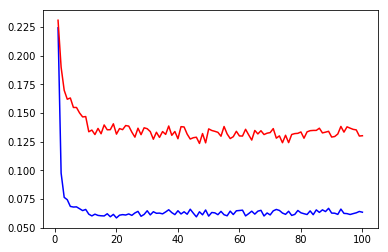

In [44]:
#Plot error as number of features increase
train_errors = []
test_errors = []

for i in np.arange(1,101):
    features = important_features[:i]
    rf = RandomForestRegressor()
    rf.fit(X_train[features],y_train)
    
    train_predicts = rf.predict(X_train[features])
    test_predicts = rf.predict(X_test[features])
    
    train_error = np.sqrt(mean_squared_error(train_predicts,y_train))
    test_error = np.sqrt(mean_squared_error(test_predicts,y_test))
    
    train_errors.append(train_error)
    test_errors.append(test_error)

num_features = np.arange(1,101)
plt.plot(num_features,train_errors,color="blue")
plt.plot(num_features,test_errors,color="red")
plt.title = "Random Forest Features"
plt.xlabel = "Number of Features"
plt.ylabel = "RMSE"

num_feature_errors = sorted(list(zip(num_features, test_errors)),key=lambda x: x[1],reverse=True)  

In [45]:
#best number of features based on test errors
best_number_of_features = sorted(list(zip(num_features, test_errors)),key=lambda x: x[1])[0]
best_rf_features = important_features[:best_number_of_features[0]]

In [46]:
#Find the optimal hyperparameters for the random forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2,  n_jobs = -1)

In [ ]:
new_rf = rf_random.fit(x, y)
new_rf.best_params_

In [49]:
#Output predictions from random forest
rf_x = X_train[best_rf_features]
rf = RandomForestRegressor(bootstrap=False, max_depth=110, max_features = 'sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators = 200)
rf.fit(rf_x, y_train)

rf_train = cross_val_predict(rf, rf_x, y_train, cv=5)
rf_test = cross_val_predict(rf, X_test[best_rf_features], y_test, cv=5)
rmse_rf_train = np.sqrt(mean_squared_error(rf_train, y_train))
rmse_rf_test = np.sqrt(mean_squared_error(rf_test, y_test))

print("The train rmse of the random forest is {}".format(round(rmse_rf_train,4)))
print("The test rmse of the random forest is {}".format(round(rmse_rf_test,4)))

The train rmse of the random forest is 0.1334
The test rmse of the random forest is 0.1457


In [50]:
#Find important features for GBR model
clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)

features = sorted(list(zip(clf.feature_importances_, X_train.columns)), reverse=True)[:100]
features_to_use = [i[1] for i in features]

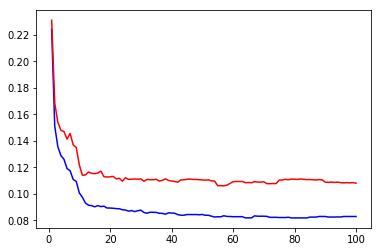

In [51]:
#Plot error as number of features increase
train_errors = []
test_errors = []

for i in np.arange(1,101):
    features = important_features[:i]
    GBR = GradientBoostingRegressor()
    GBR.fit(X_train[features],y_train)
    
    train_predicts = GBR.predict(X_train[features])
    test_predicts = GBR.predict(X_test[features])
    
    train_error = np.sqrt(mean_squared_error(train_predicts,y_train))
    test_error = np.sqrt(mean_squared_error(test_predicts,y_test))
    
    train_errors.append(train_error)
    test_errors.append(test_error)

num_features = np.arange(1,101)
plt.plot(num_features,train_errors,color="blue")
plt.plot(num_features,test_errors,color="red")
plt.title = "GBR Features"
plt.xlabel = "Number of Features"
plt.ylabel = "RMSE"

num_feature_errors = sorted(list(zip(num_features, test_errors)),key=lambda x: x[1]) 

In [52]:
#best number of features based on test errors
best_number_of_features = sorted(list(zip(num_features, test_errors)),key=lambda x: x[1])[0][0]
best_features = features_to_use[:best_number_of_features]

In [53]:
clf = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

clf.fit(X_train[best_features], y_train)

clf_train = cross_val_predict(clf, X_train[best_features], y_train, cv=5)
clf_test = cross_val_predict(clf, X_test[best_features], y_test, cv=5)

rmse_clf_train = np.sqrt(mean_squared_error(clf_train, y_train))
rmse_clf_test = np.sqrt(mean_squared_error(clf_test, y_test))


print("The train rmse of the GBR is {}".format(round(rmse_clf_train,4)))
print("The test rmse of the GBR is {}".format(round(rmse_clf_test,4)))



The train rmse of the GBR is 0.122
The test rmse of the GBR is 0.1389


In [54]:
#Create the dataframes for the stacked model
train_data = {"Random Forest":rf_train, "Lasso":lasso_train, "Ridge":ridge_train, "GBR": clf_train}
test_data = {"Random Forest": rf_test, "Lasso":lasso_test, "Ridge":ridge_test, "GBR":clf_test}
train_stacked = pd.DataFrame(train_data)
test_stacked = pd.DataFrame(test_data)

In [ ]:
#Fit an Elastic net on the stacked dataset
new_x = train_stacked
new_y = y_train

kf = KFold(n_splits=10)
alphas = np.linspace(.005,30,30)

train_rmses = []
test_rmses = [] 
for alpha in alphas:
    current_train_rmse = []
    current_test_rmse = []
    
    for train_index, test_index in kf.split(new_x):
        print("Train:",train_index," Test:",test_index)
        x_trains,x_tests = new_x.iloc[train_index,:],new_x.iloc[test_index,:]
        y_trains, y_tests = new_y.iloc[train_index], new_y.iloc[test_index]
        
        elastic_net = ElasticNet(alpha=alpha)
        elastic_net.fit(x_trains,y_trains)
        
        train_predict = elastic_net.predict(x_trains)
        test_predict = elastic_net.predict(x_tests)
        
        train_rmse= np.sqrt(mean_squared_error(train_predict, y_trains))
        test_rmse = np.sqrt(mean_squared_error(test_predict,y_tests))
        
        current_train_rmse.append(train_rmse)
        current_test_rmse.append(test_rmse)
    
    train_rmses.append(np.mean(current_train_rmse))
    test_rmses.append(np.mean(current_test_rmse))

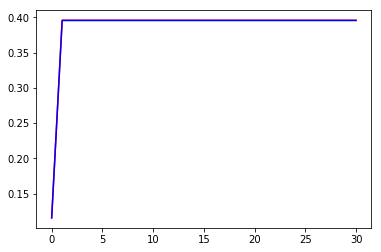

In [61]:
plt.plot(alphas,train_rmses,color="red")
plt.plot(alphas,test_rmses,color="blue")

In [62]:
final_elastic_net = ElasticNet(alpha=.005)

final_elastic_net.fit(new_x, new_y)

e_test_pred = final_elastic_net.predict(test_stacked)
new_test_rmse = np.sqrt(mean_squared_error(y_test, e_test_pred))

In [ ]:
#Run the model on the test data data for submission
def lasso_predictions(df):  
    return final_lasso.predict(df[best_coefs])

def ridge_predictions(df):   
    return final_ridge.predict(df)

def rf_predictions(df):
    return rf.predict(df[best_rf_features])

def clf_predictions(df):
    return clf.predict(df[best_features])

def elastic_net_predictions(df):
    lasso = lasso_predictions(df)
    ridge = ridge_predictions(df)
    rf = rf_predictions(df)
    clf = clf_predictions(df)
    
    stacked_data = {"Random Forest":rf, "Lasso":lasso, "Ridge":ridge, "clf":clf}
    test_df = pd.DataFrame(stacked_data)
    
    return e**final_elastic_net.predict(test_df)



In [ ]:
final = elastic_net_predictions(final_test)

In [ ]:
to_submit_dict = {"SalePrice":final,"id":test_id}
to_submit = pd.DataFrame(to_submit_dict)
to_submit = to_submit[["id","SalePrice"]]

In [ ]:
to_submit.to_csv("submission3.csv",index=False)